## Hyporheic Averaging Based on Turbidity Threshold

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import linregress
import matplotlib.dates as mdates

# import the data, and make first column the index 
sp_sample_SSC = pd.read_csv('../../../data/SSC/temp_corrected_SSC/samples_spring_SSC_corrected.csv', index_col=2, parse_dates=True)
sm_sample_SSC = pd.read_csv('../../../data/SSC/temp_corrected_SSC/samples_summer_SSC_corrected.csv', index_col=2, parse_dates=True)
sp_turb = pd.read_csv('../../../data/SSC/turb_SP23_clean_complete.csv', index_col=0, parse_dates=True)
sm_turb = pd.read_csv('../../../data/SSC/turb_SM23_clean_complete.csv', index_col=0, parse_dates=True)

# in the samples, only keep sample names that start with "UP"
sp_sample_SSC = sp_sample_SSC[sp_sample_SSC['Sample '].str.startswith("UP")]
# in the summer, keep sample names containing "UP"
sm_sample_SSC = sm_sample_SSC[sm_sample_SSC['Sample '].str.contains("U")]

# drop nan values 
sp_sample_SSC = sp_sample_SSC.dropna()
sm_sample_SSC = sm_sample_SSC.dropna()
sp_turb = sp_turb.dropna()
sm_turb = sm_turb.dropna()

# deleting duplicates, in case there are any
sm_turb = sm_turb[~sm_turb.index.duplicated(keep='first')]
sp_turb = sp_turb[~sp_turb.index.duplicated(keep='first')]
sm_turb = sm_turb.sort_index()
sp_turb = sp_turb.sort_index()

# resample the data to 1 minute intervals and interpolate
sp_turb = sp_turb.resample('1T').interpolate()
sm_turb = sm_turb.resample('1T').interpolate()

# merge turbidity onto sample data on the dates
sp_sample_SSC = sp_sample_SSC.merge(sp_turb, on='Date_Time')
sm_sample_SSC = sm_sample_SSC.merge(sm_turb, on='Date_Time')

# delete outlier samples
sp_sample_SSC = sp_sample_SSC[~sp_sample_SSC['Sample '].isin(['UP77', 'UP82'])]
sm_sample_SSC = sm_sample_SSC[~sm_sample_SSC['Sample '].str.contains('ST5|ST6')]


Merge turbidity to the sample data 

#### Scatter Plots

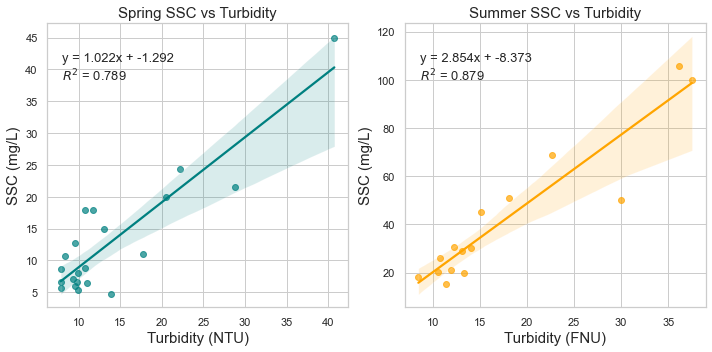

In [2]:
# Combined scatter plot for both seasons as subplots
sns.set(style="whitegrid") 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Spring subplot
x_sp = sp_sample_SSC['TurbClean']
y_sp = sp_sample_SSC['SSC']
slope_sp, intercept_sp, r_value_sp, p_value_sp, std_err_sp = linregress(x_sp, y_sp)

sns.regplot(data=sp_sample_SSC, x='TurbClean', y='SSC', 
            scatter_kws={'alpha': 0.7}, 
            line_kws={'color': 'teal'}, color='teal', ax=axes[0])

# Add Spring equation and R²
eq_text_sp = f"y = {slope_sp:.3f}x + {intercept_sp:.3f}\n$R^2$ = {r_value_sp**2:.3f}"
axes[0].text(0.05, 0.90, eq_text_sp, transform=axes[0].transAxes, 
             fontsize=13, verticalalignment='top')

axes[0].set_title('Spring SSC vs Turbidity', fontsize=15)
axes[0].set_xlabel('Turbidity (NTU)', fontsize=15)
axes[0].set_ylabel('SSC (mg/L)', fontsize=15)

# Summer subplot
x_sm = sm_sample_SSC['TurbClean']
y_sm = sm_sample_SSC['SSC']
slope_sm, intercept_sm, r_value_sm, p_value_sm, std_err_sm = linregress(x_sm, y_sm)

sns.regplot(data=sm_sample_SSC, x='TurbClean', y='SSC', 
            scatter_kws={'alpha': 0.7}, 
            line_kws={'color': 'orange'}, color='orange', ax=axes[1])

# Add Summer equation and R²
eq_text_sm = f"y = {slope_sm:.3f}x + {intercept_sm:.3f}\n$R^2$ = {r_value_sm**2:.3f}"
axes[1].text(0.05, 0.90, eq_text_sm, transform=axes[1].transAxes, 
             fontsize=13, verticalalignment='top')

axes[1].set_title('Summer SSC vs Turbidity', fontsize=15)
axes[1].set_xlabel('Turbidity (FNU)', fontsize=15)
axes[1].set_ylabel('SSC (mg/L)', fontsize=15)

plt.tight_layout()
plt.savefig('SSC_vs_Turbidity_RatingCurves.jpg', dpi=500)
plt.show()

Note: cannot combine for a total rating curve, because turbidity units are different between seasons (FNU vs NTU)

#### Time Series

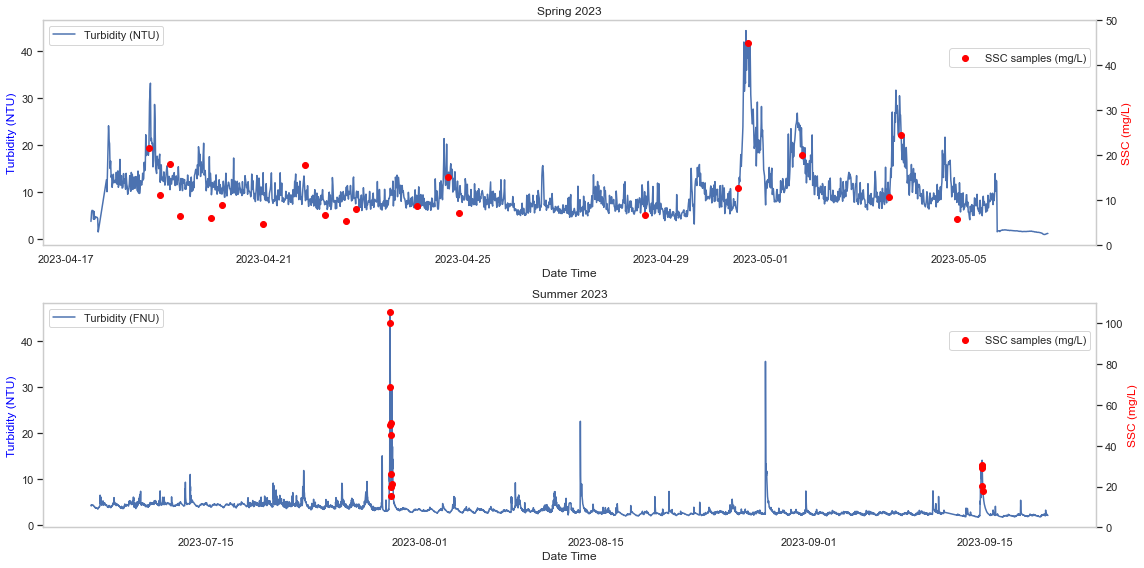

In [3]:
# plot turbidity and SSC concentration time series for both seasons 
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(sp_turb.index, sp_turb['TurbClean'], 'b-', label='Turbidity (NTU)')
ax2.scatter(sp_sample_SSC.index, sp_sample_SSC['SSC'], c='red', marker='o', label='SSC samples (mg/L)')

ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='blue')
ax2.set_ylabel('SSC (mg/L)', color='red'    )
ax2.set_ylim(0,50)
ax1[0].set_title('Spring 2023')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(sm_turb.index, sm_turb['TurbClean'], 'b-', label='Turbidity (FNU)')
ax2.scatter(sm_sample_SSC.index, sm_sample_SSC['SSC'], c='red', marker='o', label='SSC samples (mg/L)')

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='blue')
ax2.set_ylabel('SSC (mg/L)', color='red')
ax2.set_ylim(0,110)
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

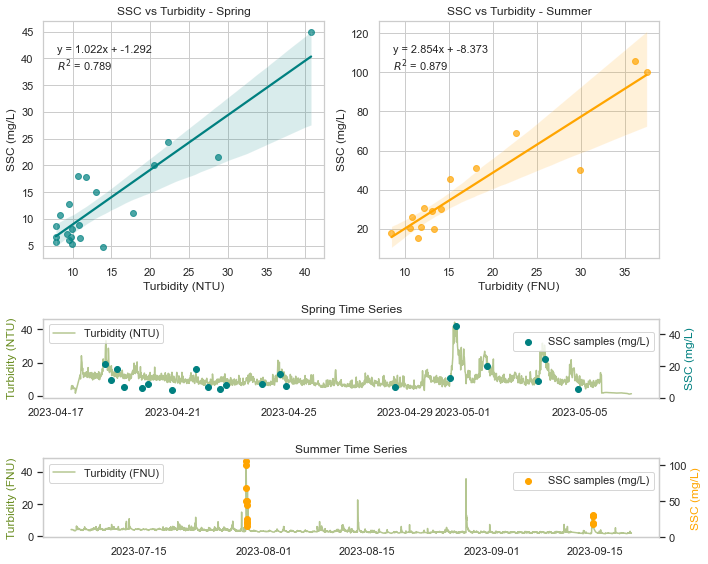

In [4]:
# Create the figure using subplot_mosaic for a custom layout
fig = plt.figure(figsize=(10, 8))
ax_dict = fig.subplot_mosaic([['spring_reg', 'summer_reg'],
                              ['spring_ts', 'spring_ts'],
                              ['summer_ts', 'summer_ts']],
                             gridspec_kw={'height_ratios': [3, 1, 1]})
sns.set(style="whitegrid")

# TOP ROW: REGRESSION PLOTS
ax_spring_reg = ax_dict['spring_reg']
ax_summer_reg = ax_dict['summer_reg']

# Spring Regression (top-left)
x_sp = sp_sample_SSC['TurbClean']
y_sp = sp_sample_SSC['SSC']
slope_sp, intercept_sp, r_value_sp, _, _ = linregress(x_sp, y_sp)
sns.regplot(data=sp_sample_SSC, x='TurbClean', y='SSC',
            scatter_kws={'alpha': 0.7},
            line_kws={'color': 'teal'}, color='teal', ax=ax_spring_reg)
eq_text_sp = f"y = {slope_sp:.3f}x + {intercept_sp:.3f}\n$R^2$ = {r_value_sp**2:.3f}"
ax_spring_reg.text(0.05, 0.90, eq_text_sp, transform=ax_spring_reg.transAxes,
                   fontsize=11, verticalalignment='top')
ax_spring_reg.set_title('SSC vs Turbidity - Spring', fontsize=12)
ax_spring_reg.set_xlabel('Turbidity (NTU)', fontsize=12)
ax_spring_reg.set_ylabel('SSC (mg/L)', fontsize=12)

# Summer Regression (top-right)
x_sm = sm_sample_SSC['TurbClean']
y_sm = sm_sample_SSC['SSC']
slope_sm, intercept_sm, r_value_sm, _, _ = linregress(x_sm, y_sm)
sns.regplot(data=sm_sample_SSC, x='TurbClean', y='SSC',
            scatter_kws={'alpha': 0.7},
            line_kws={'color': 'orange'}, color='orange', ax=ax_summer_reg)
eq_text_sm = f"y = {slope_sm:.3f}x + {intercept_sm:.3f}\n$R^2$ = {r_value_sm**2:.3f}"
ax_summer_reg.text(0.05, 0.90, eq_text_sm, transform=ax_summer_reg.transAxes,
                   fontsize=11, verticalalignment='top')
ax_summer_reg.set_title('SSC vs Turbidity - Summer', fontsize=12)
ax_summer_reg.set_xlabel('Turbidity (FNU)', fontsize=12)
ax_summer_reg.set_ylabel('SSC (mg/L)', fontsize=12)

# BOTTOM ROWS: TIME SERIES PLOTS
ax_spring_ts = ax_dict['spring_ts']
ax_summer_ts = ax_dict['summer_ts']

# Spring Time Series (bottom-spanning top half)
ax_sp_ssc = ax_spring_ts.twinx()
ax_spring_ts.plot(sp_turb.index, sp_turb['TurbClean'], color='olivedrab', label='Turbidity (NTU)', alpha=0.5)
ax_sp_ssc.scatter(sp_sample_SSC.index, sp_sample_SSC['SSC'], c='teal', marker='o', label='SSC samples (mg/L)')
#ax_spring_ts.set_xlabel('Date Time', fontsize=12)
ax_spring_ts.set_ylabel('Turbidity (NTU)', color='olivedrab', fontsize=12)
ax_sp_ssc.set_ylabel('SSC (mg/L)', color='teal', fontsize=12)
ax_sp_ssc.set_ylim(0, 50)
ax_spring_ts.set_title('Spring Time Series', fontsize=12)
ax_spring_ts.legend(loc='upper left')
ax_sp_ssc.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax_spring_ts.grid(False)
ax_sp_ssc.grid(False)

# Summer Time Series (bottom-spanning bottom half)
ax_sm_ssc = ax_summer_ts.twinx()
ax_summer_ts.plot(sm_turb.index, sm_turb['TurbClean'], color='olivedrab', label='Turbidity (FNU)', alpha=0.5)
ax_sm_ssc.scatter(sm_sample_SSC.index, sm_sample_SSC['SSC'], c='orange', marker='o', label='SSC samples (mg/L)')
#ax_summer_ts.set_xlabel('Date Time', fontsize=12)
ax_summer_ts.set_ylabel('Turbidity (FNU)', color='olivedrab', fontsize=12)
ax_sm_ssc.set_ylabel('SSC (mg/L)', color='orange', fontsize=12)
ax_sm_ssc.set_ylim(0, 110)
ax_summer_ts.set_title('Summer Time Series', fontsize=12)
ax_summer_ts.legend(loc='upper left')
ax_sm_ssc.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax_summer_ts.grid(False)
ax_sm_ssc.grid(False)

plt.tight_layout()
plt.savefig('Combined_Regression_TimeSeries.jpg', dpi=500)
plt.show()

### Calculating Turbidity Threshold

Functions

In [5]:
def merge_Q_turb(df_Q: pd.DataFrame, df_T: pd.DataFrame, q_col_name: str, turb_col_name: str, how: str = "inner",):
    # checking if the columns exist in the dataframes
    if q_col_name not in df_Q.columns:
        raise KeyError(f"'{q_col_name}' not found in df_Q columns")
    if turb_col_name not in df_T.columns:
        raise KeyError(f"'{turb_col_name}' not found in df_T columns")
    # merging the dataframes
    merged = (df_Q[[q_col_name]].merge(df_T[[turb_col_name]], left_index=True, right_index=True, how=how))
    return merged

Importing Discahrge Data

In [6]:
# import the discharge data
q = pd.read_csv('../../../data/discharge/discharge_2023.csv', index_col=0, parse_dates=True)

# separate the spring and summer data
q_sp = q.loc['2023-04-15':'2023-05-15']
q_sm = q.loc['2023-07-01':'2023-09-17']

merged_sp = merge_Q_turb(q_sp, sp_turb, q_col_name="Q", turb_col_name="TurbClean", how="inner")
merged_sm = merge_Q_turb(q_sm, sm_turb, q_col_name="Q", turb_col_name="TurbClean", how="inner")

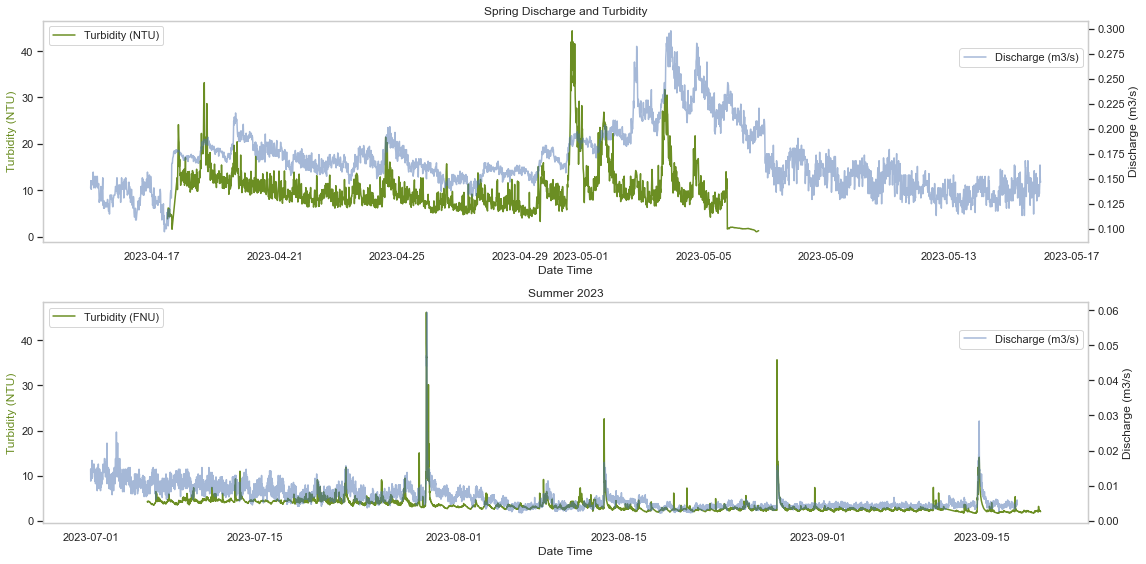

In [7]:
# plot turbidity and SSC concentration time series for both seasons 
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(sp_turb.index, sp_turb['TurbClean'], color='olivedrab', label='Turbidity (NTU)')
ax2.plot(q_sp.index, q_sp['Q'], label='Discharge (m3/s)', alpha=0.5)


ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='olivedrab')
ax2.set_ylabel('Discharge (m3/s)')
ax1[0].set_title('Spring Discharge and Turbidity')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(sm_turb.index, sm_turb['TurbClean'], color='olivedrab', label='Turbidity (FNU)')
ax2.plot(q_sm.index, q_sm['Q'], label='Discharge (m3/s)', alpha=0.5)

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='olivedrab')
ax2.set_ylabel('Discharge (m3/s)')
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

### Plotting Different Threshold Methods

SSC Rating Curve Threshold

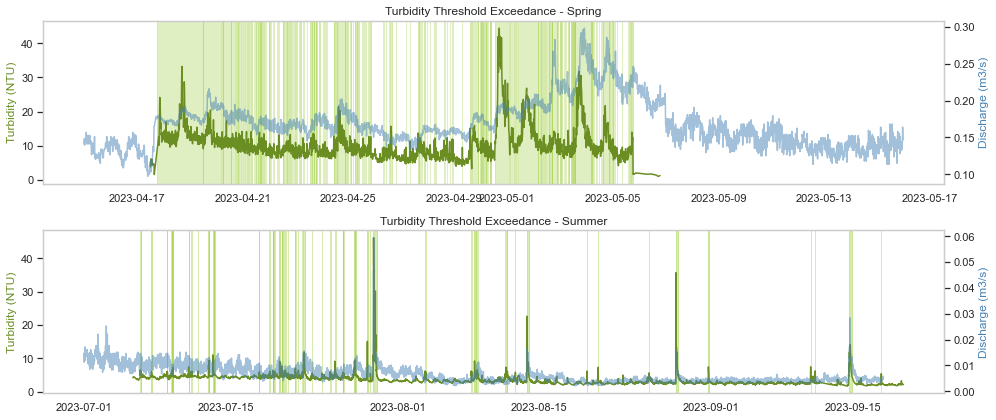

In [8]:
# input the turbidity threshold
spring_threshold = 9.3375
summer_threshold = 5.3504

fig, ax1 = plt.subplots(2, 1, figsize=(14, 6)) 

### SPRING ###
ax2 = ax1[0].twinx()
ax1[0].plot(sp_turb.index, sp_turb['TurbClean'], color='olivedrab', label='Turbidity (NTU)')
ax2.plot(q_sp.index, q_sp['Q'], label='Discharge (m3/s)', alpha=0.5, color='steelblue')

# find spring exceedance regions
spring_exceeds = sp_turb['TurbClean'] > spring_threshold
spring_regions = []
in_event = False
for i in range(len(spring_exceeds)):
    if spring_exceeds.iloc[i] and not in_event:
        start = sp_turb.index[i]
        in_event = True
    elif not spring_exceeds.iloc[i] and in_event:
        end = sp_turb.index[i]
        spring_regions.append((start, end))
        in_event = False
if in_event:
    spring_regions.append((start, sp_turb.index[-1]))

# highlight spring exceedance periods
for start, end in spring_regions:
    ax1[0].axvspan(start, end, color='yellowgreen', alpha=0.3)

ax1[0].set_ylabel('Turbidity (NTU)', color='olivedrab')
ax2.set_ylabel('Discharge (m3/s)', color='steelblue')
ax1[0].set_title('Turbidity Threshold Exceedance - Spring')
#ax1[0].legend(loc='upper left')
#ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[0].grid(False)
ax2.grid(False)

### SUMMER ###
ax2 = ax1[1].twinx()
ax1[1].plot(sm_turb.index, sm_turb['TurbClean'], color='olivedrab', label='Turbidity (FNU)')
ax2.plot(q_sm.index, q_sm['Q'], label='Discharge (m3/s)', alpha=0.5, color='steelblue')

# find summer exceedance regions
summer_exceeds = sm_turb['TurbClean'] > summer_threshold
summer_regions = []
in_event = False
for i in range(len(summer_exceeds)):
    if summer_exceeds.iloc[i] and not in_event:
        start = sm_turb.index[i]
        in_event = True
    elif not summer_exceeds.iloc[i] and in_event:
        end = sm_turb.index[i]
        summer_regions.append((start, end))
        in_event = False
if in_event:
    summer_regions.append((start, sm_turb.index[-1]))

# highlight summer exceedance periods
for start, end in summer_regions:
    ax1[1].axvspan(start, end, color='yellowgreen', alpha=0.4)

ax1[1].set_ylabel('Turbidity (NTU)', color='olivedrab')
ax2.set_ylabel('Discharge (m3/s)', color='steelblue')
ax1[1].set_title('Turbidity Threshold Exceedance - Summer')
#ax1[1].legend(loc='upper left')
#ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.savefig('Turbidity_Threshold_Exceedance.jpg', dpi=500)
plt.show()

### Getting Exceedance Periods

In [9]:
def get_exceedance_periods(df, turb_col, threshold, season_label):
    exceedances = df[turb_col] > threshold
    periods = []
    in_event = False
    for i in range(len(exceedances)):
        if exceedances.iloc[i] and not in_event:
            start = df.index[i]
            in_event = True
        elif not exceedances.iloc[i] and in_event:
            end = df.index[i]
            periods.append((season_label, start, end))
            in_event = False
    if in_event:
        periods.append((season_label, start, df.index[-1]))
    return periods

In [10]:
# get periods for spring and summer
spring_threshold = 9.33
summer_threshold = 5.35

spring_periods = get_exceedance_periods(sp_turb, 'TurbClean', spring_threshold, 'spring')
summer_periods = get_exceedance_periods(sm_turb, 'TurbClean', summer_threshold, 'summer')
# combine and export
all_periods = spring_periods + summer_periods
df_periods = pd.DataFrame(all_periods, columns=['season', 'start', 'end'])
rating_curve_periods = df_periods.copy()

# print the result
print(df_periods)
# export to CSV
df_periods.to_csv('turb_exceedance_periods.csv', index=False)

# calculate total exceedance time
df_periods['start'] = pd.to_datetime(df_periods['start'])
df_periods['end'] = pd.to_datetime(df_periods['end'])
# calculate duration for each row
df_periods['duration'] = df_periods['end'] - df_periods['start']
# group by season and sum durations
duration_by_season = df_periods.groupby('season')['duration'].sum()
# convert to minutes
duration_minutes = duration_by_season.apply(lambda x: x.total_seconds() / 60)
# print result
for season, minutes in duration_minutes.items():
    print(f"Total exceedance time in {season}: {minutes:.2f} minutes")


     season               start                 end
0    spring 2023-04-17 18:32:00 2023-04-19 12:13:00
1    spring 2023-04-19 12:17:00 2023-04-20 04:42:00
2    spring 2023-04-20 05:02:00 2023-04-20 05:58:00
3    spring 2023-04-20 06:00:00 2023-04-20 13:14:00
4    spring 2023-04-20 13:15:00 2023-04-20 17:24:00
..      ...                 ...                 ...
263  summer 2023-08-31 17:23:00 2023-08-31 17:55:00
264  summer 2023-09-10 19:47:00 2023-09-10 20:34:00
265  summer 2023-09-11 06:57:00 2023-09-11 07:08:00
266  summer 2023-09-14 14:40:00 2023-09-14 21:17:00
267  summer 2023-09-17 19:45:00 2023-09-17 19:46:00

[268 rows x 3 columns]
Total exceedance time in spring: 12912.00 minutes
Total exceedance time in summer: 4096.00 minutes


### Averaging Hyporheic Fluxes

In [11]:
spring_HF = pd.read_csv('../../../data/hyporheic_fluxes/spring_HF.csv', index_col=0, parse_dates=True)
summer_HF = pd.read_csv('../../../data/hyporheic_fluxes/summer_HF.csv', index_col=0, parse_dates=True)

# interpolate to get 1m intervals
spring_HF = spring_HF.resample('1T').interpolate()
summer_HF = summer_HF.resample('1T').interpolate()

In [12]:
# SPRING 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in rating_curve_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = spring_HF.loc[(spring_HF.index >= start) & (spring_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = spring_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF (m/s)']
# calculate in m/day
mean_hf_exceedance['Avg HF (m/day)'] = mean_hf_exceedance['Avg HF (m/s)'] * 86400
print(mean_hf_exceedance)
# export to csv
mean_hf_exceedance.to_csv('avg_VHF/spring_avgHF.csv', index=False)


  Probe  Avg HF (m/s)  Avg HF (m/day)
0    T1  2.367403e-06        0.204544
1    T2 -3.664511e-06       -0.316614
2    T3 -1.275140e-06       -0.110172
3    T5  6.991410e-07        0.060406
4    T6 -4.020014e-07       -0.034733
5    T7 -1.938243e-06       -0.167464
6    T8 -3.863237e-07       -0.033378


In [13]:
# SUMMER 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in rating_curve_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = summer_HF.loc[(summer_HF.index >= start) & (summer_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = summer_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF (m/s)']
# calculate in m/day
mean_hf_exceedance['Avg HF (m/day)'] = mean_hf_exceedance['Avg HF (m/s)'] * 86400
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('avg_VHF/summer_avgHF.csv', index=False)

  Probe  Avg HF (m/s)  Avg HF (m/day)
0    T1 -2.968021e-06       -0.256437
1    T2 -3.778617e-06       -0.326472
2    T3 -3.467455e-06       -0.299588
3    T5  1.028768e-06        0.088886
4    T6 -6.712630e-07       -0.057997
5    T7 -1.432787e-06       -0.123793
6    T8 -6.070963e-07       -0.052453


## Final Plot

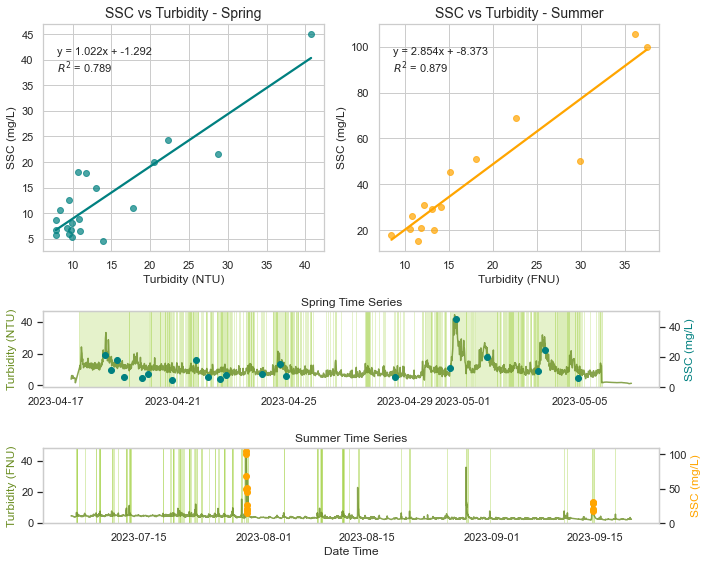

In [15]:
spring_threshold = 9.3375
summer_threshold = 5.3504

# Create the figure using subplot_mosaic for a custom layout
fig = plt.figure(figsize=(10, 8))
ax_dict = fig.subplot_mosaic([['spring_reg', 'summer_reg'],
                                ['spring_ts', 'spring_ts'],
                                ['summer_ts', 'summer_ts']],
                                gridspec_kw={'height_ratios': [3, 1, 1]})
sns.set(style="whitegrid")

# TOP ROW: REGRESSION PLOTS
ax_spring_reg = ax_dict['spring_reg']
ax_summer_reg = ax_dict['summer_reg']

# Spring Regression (top-left)
x_sp = sp_sample_SSC['TurbClean']
y_sp = sp_sample_SSC['SSC']
slope_sp, intercept_sp, r_value_sp, _, _ = linregress(x_sp, y_sp)
sns.regplot(data=sp_sample_SSC, x='TurbClean', y='SSC',
            scatter_kws={'alpha': 0.7},
            line_kws={'color': 'teal'}, color='teal', ax=ax_spring_reg, ci=None)
eq_text_sp = f"y = {slope_sp:.3f}x + {intercept_sp:.3f}\n$R^2$ = {r_value_sp**2:.3f}"
ax_spring_reg.text(0.05, 0.90, eq_text_sp, transform=ax_spring_reg.transAxes,
                   fontsize=11, verticalalignment='top')
ax_spring_reg.set_title('SSC vs Turbidity - Spring', fontsize=14)
ax_spring_reg.set_xlabel('Turbidity (NTU)', fontsize=12)
ax_spring_reg.set_ylabel('SSC (mg/L)', fontsize=12)

# Summer Regression (top-right)
x_sm = sm_sample_SSC['TurbClean']
y_sm = sm_sample_SSC['SSC']
slope_sm, intercept_sm, r_value_sm, _, _ = linregress(x_sm, y_sm)
sns.regplot(data=sm_sample_SSC, x='TurbClean', y='SSC',
            scatter_kws={'alpha': 0.7},
            line_kws={'color': 'orange'}, color='orange', ax=ax_summer_reg, ci=None)
eq_text_sm = f"y = {slope_sm:.3f}x + {intercept_sm:.3f}\n$R^2$ = {r_value_sm**2:.3f}"
ax_summer_reg.text(0.05, 0.90, eq_text_sm, transform=ax_summer_reg.transAxes,
                   fontsize=11, verticalalignment='top')
ax_summer_reg.set_title('SSC vs Turbidity - Summer', fontsize=14)
ax_summer_reg.set_xlabel('Turbidity (FNU)', fontsize=12)
ax_summer_reg.set_ylabel('SSC (mg/L)', fontsize=12)


# BOTTOM ROWS: TIME SERIES PLOTS
ax_spring_ts = ax_dict['spring_ts']
ax_summer_ts = ax_dict['summer_ts']

# Spring Time Series (bottom-spanning top half)
ax_sp_ssc = ax_spring_ts.twinx()
ax_spring_ts.plot(sp_turb.index, sp_turb['TurbClean'], color='olivedrab', label='Turbidity (NTU)', alpha=0.8)
ax_sp_ssc.scatter(sp_sample_SSC.index, sp_sample_SSC['SSC'], c='teal', marker='o', label='SSC samples (mg/L)')

# Find and highlight spring exceedance regions
spring_exceeds = sp_turb['TurbClean'] > spring_threshold
spring_regions = []
in_event = False
for i in range(len(spring_exceeds)):
    if spring_exceeds.iloc[i] and not in_event:
        start = sp_turb.index[i]
        in_event = True
    elif not spring_exceeds.iloc[i] and in_event:
        end = sp_turb.index[i]
        spring_regions.append((start, end))
        in_event = False
if in_event:
    spring_regions.append((start, sp_turb.index[-1]))
for start, end in spring_regions:
    ax_spring_ts.axvspan(start, end, color='yellowgreen', alpha=0.25)

ax_spring_ts.set_ylabel('Turbidity (NTU)', color='olivedrab', fontsize=12)
ax_sp_ssc.set_ylabel('SSC (mg/L)', color='teal', fontsize=12)
ax_sp_ssc.set_ylim(0, 50)
ax_spring_ts.set_title('Spring Time Series', fontsize=12)
ax_spring_ts.grid(False)
ax_sp_ssc.grid(False)

# Summer Time Series (bottom-spanning bottom half)
ax_sm_ssc = ax_summer_ts.twinx()
ax_summer_ts.plot(sm_turb.index, sm_turb['TurbClean'], color='olivedrab', label='Turbidity (FNU)', alpha=0.8)
ax_sm_ssc.scatter(sm_sample_SSC.index, sm_sample_SSC['SSC'], c='orange', marker='o', label='SSC samples (mg/L)')

# Find and highlight summer exceedance regions
summer_exceeds = sm_turb['TurbClean'] > summer_threshold
summer_regions = []
in_event = False
for i in range(len(summer_exceeds)):
    if summer_exceeds.iloc[i] and not in_event:
        start = sm_turb.index[i]
        in_event = True
    elif not summer_exceeds.iloc[i] and in_event:
        end = sm_turb.index[i]
        summer_regions.append((start, end))
        in_event = False
if in_event:
    summer_regions.append((start, sm_turb.index[-1]))
for start, end in summer_regions:
    ax_summer_ts.axvspan(start, end, color='yellowgreen', alpha=0.35)

ax_summer_ts.set_xlabel('Date Time', fontsize=12)
ax_summer_ts.set_ylabel('Turbidity (FNU)', color='olivedrab', fontsize=12)
ax_sm_ssc.set_ylabel('SSC (mg/L)', color='orange', fontsize=12)
ax_sm_ssc.set_ylim(0, 110)
ax_summer_ts.set_title('Summer Time Series', fontsize=12)
ax_summer_ts.grid(False)
ax_sm_ssc.grid(False)

plt.tight_layout()
plt.savefig('Combined_Plot_with_Exceedance.jpg', dpi=500)
plt.show()

In [20]:
spring_threshold = 9.3375
summer_threshold = 5.3504

# spring 
# Calculate SSC from regression, but set SSC to 0 when turbidity is below the threshold (9.33)
sp_turb['SSC_calculated'] = slope_sp * sp_turb['TurbClean'] + intercept_sp
# where turbidity is below threshold, set SSC to 0                  
sp_turb['SSC_calculated'] = sp_turb['SSC_calculated'].where(sp_turb['TurbClean'] >= spring_threshold, 0)

# summer 
sm_turb['SSC_calculated'] = slope_sm * sm_turb['TurbClean'] + intercept_sm
# where turbidity is below threshold, set SSC to 0
sm_turb['SSC_calculated'] = sm_turb['SSC_calculated'].where(sm_turb['TurbClean'] >= summer_threshold, 0)


Plotting VHF instead of turbidity 

In [33]:
VHF_spring = pd.read_csv('../../../data/hyporheic_fluxes/spring_HF.csv', index_col=0, parse_dates=True)
VHF_summer = pd.read_csv('../../../data/hyporheic_fluxes/summer_HF.csv', index_col=0, parse_dates=True)

# keep data from 04/15/2023 to 05/15/2023 for spring
VHF_spring = VHF_spring.loc['2023-04-15':'2023-05-10']
# keep data from 07/01/2023 to 09/17/2023 for summer
VHF_summer = VHF_summer.loc['2023-07-01':'2023-09-18']

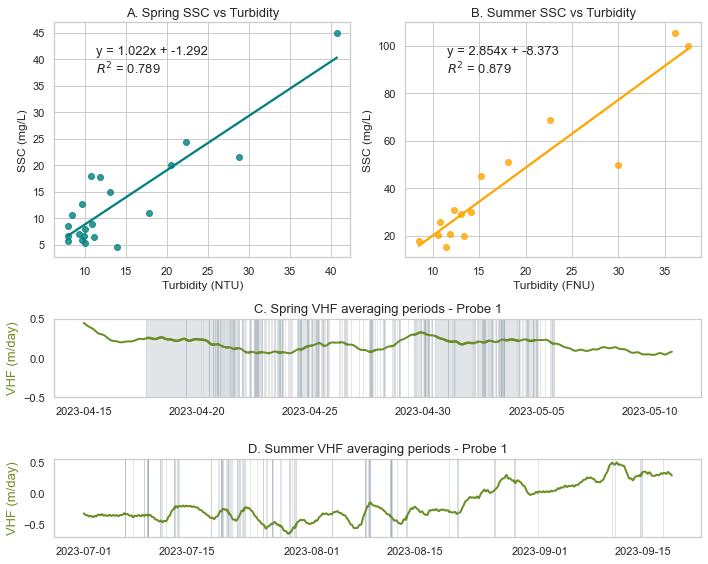

In [56]:
# Create the figure using subplot_mosaic for a custom layout
fig = plt.figure(figsize=(10, 8))
ax_dict = fig.subplot_mosaic([['spring_reg', 'summer_reg'],
                                ['spring_ts', 'spring_ts'],
                                ['summer_ts', 'summer_ts']],
                                gridspec_kw={'height_ratios': [3, 1, 1]})
sns.set(style="whitegrid")

# TOP ROW: REGRESSION PLOTS
ax_spring_reg = ax_dict['spring_reg']
ax_summer_reg = ax_dict['summer_reg']

# Spring Regression (top-left)
x_sp = sp_sample_SSC['TurbClean']
y_sp = sp_sample_SSC['SSC']
slope_sp, intercept_sp, r_value_sp, _, _ = linregress(x_sp, y_sp)
sns.regplot(data=sp_sample_SSC, x='TurbClean', y='SSC',
            scatter_kws={'alpha': 0.8},
            line_kws={'color': 'teal'}, color='teal', ax=ax_spring_reg, ci=None)
eq_text_sp = f"y = {slope_sp:.3f}x + {intercept_sp:.3f}\n$R^2$ = {r_value_sp**2:.3f}"
ax_spring_reg.text(0.14, 0.90, eq_text_sp, transform=ax_spring_reg.transAxes,
                   fontsize=13, verticalalignment='top')
ax_spring_reg.set_title('A. Spring SSC vs Turbidity', fontsize=13)
ax_spring_reg.set_xlabel('Turbidity (NTU)', fontsize=12)
ax_spring_reg.set_ylabel('SSC (mg/L)', fontsize=12)

# Summer Regression (top-right)
x_sm = sm_sample_SSC['TurbClean']
y_sm = sm_sample_SSC['SSC']
slope_sm, intercept_sm, r_value_sm, _, _ = linregress(x_sm, y_sm)
sns.regplot(data=sm_sample_SSC, x='TurbClean', y='SSC',
            scatter_kws={'alpha': 0.8},
            line_kws={'color': 'orange'}, color='orange', ax=ax_summer_reg, ci=None)
eq_text_sm = f"y = {slope_sm:.3f}x + {intercept_sm:.3f}\n$R^2$ = {r_value_sm**2:.3f}"
ax_summer_reg.text(0.14, 0.90, eq_text_sm, transform=ax_summer_reg.transAxes,
                   fontsize=13, verticalalignment='top')
ax_summer_reg.set_title('B. Summer SSC vs Turbidity', fontsize=13)
ax_summer_reg.set_xlabel('Turbidity (FNU)', fontsize=12)
ax_summer_reg.set_ylabel('SSC (mg/L)', fontsize=12)


# BOTTOM ROWS: TIME SERIES PLOTS
ax_spring_ts = ax_dict['spring_ts']
ax_summer_ts = ax_dict['summer_ts']

# Spring Time Series (bottom-spanning top half)
ax_spring_ts.plot(VHF_spring.index, VHF_spring['T1']*86400, color='olivedrab', label='VHF (m/day)', linewidth=2, zorder=1)

# Find and highlight spring exceedance regions
spring_exceeds = sp_turb['TurbClean'] > spring_threshold
spring_regions = []
in_event = False
for i in range(len(spring_exceeds)):
    if spring_exceeds.iloc[i] and not in_event:
        start = sp_turb.index[i]
        in_event = True
    elif not spring_exceeds.iloc[i] and in_event:
        end = sp_turb.index[i]
        spring_regions.append((start, end))
        in_event = False
if in_event:
    spring_regions.append((start, sp_turb.index[-1]))
for start, end in spring_regions:
    # highlight the regions on the VHF plot
    ax_spring_ts.axvspan(start, end, color='slategray', alpha=0.2)
    # plot thicker line segment over the highlighted area
    vhf_segment = VHF_spring[(VHF_spring.index >= start) & (VHF_spring.index <= end)]
    ax_spring_ts.plot(vhf_segment.index, vhf_segment['T1']*86400,
                    color='olivedrab',
                    linewidth=2.5, # increased line width
                    zorder=2) # ensure it plots over the base line and shading

ax_spring_ts.set_ylabel('VHF (m/day)', color='olivedrab', fontsize=13)
ax_spring_ts.set_title('C. Spring VHF averaging periods - Probe 1', fontsize=13)
ax_spring_ts.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax_spring_ts.set_ylim(-0.5, 0.5)
ax_spring_ts.grid(False)

# Summer Time Series (bottom-spanning bottom half)
ax_summer_ts.plot(VHF_summer.index, VHF_summer['T1']*86400, color='olivedrab', label='VHF (m/day)', linewidth=2, zorder=1)
# Find and highlight summer exceedance regions
summer_exceeds = sm_turb['TurbClean'] > summer_threshold
summer_regions = []
in_event = False
for i in range(len(summer_exceeds)):
    if summer_exceeds.iloc[i] and not in_event:
        start = sm_turb.index[i]
        in_event = True
    elif not summer_exceeds.iloc[i] and in_event:
        end = sm_turb.index[i]
        summer_regions.append((start, end))
        in_event = False
if in_event:
    summer_regions.append((start, sm_turb.index[-1]))
for start, end in summer_regions:
    # highlight the regions on the VHF plot
    ax_summer_ts.axvspan(start, end, color='slategray', alpha=0.2)
    # plot thicker line segment over the highlighted area
    vhf_segment = VHF_summer[(VHF_summer.index >= start) & (VHF_summer.index <= end)]
    ax_summer_ts.plot(vhf_segment.index, vhf_segment['T1']*86400,
                    color='olivedrab',
                    linewidth=2.5, # increased line width
                    zorder=2) # ensure it plots over the base line and shading

ax_summer_ts.set_ylabel('VHF (m/day)', color='olivedrab', fontsize=13)
ax_summer_ts.set_title('D. Summer VHF averaging periods - Probe 1', fontsize=13)
ax_summer_ts.grid(False)

plt.tight_layout()
#fig.autofmt_xdate()
plt.savefig('VHF_averaging_periods.jpg', dpi=500)
plt.show()